This notebook compare the stellar mass functions predicted by the UniverseMachine model with the recent observational constraints from HSC at high mass end.  

For observation, we will consider the SMF measured using different methods and within different apertures 

For UniverseMachine models, we will consider
1. BCG, ICL, and BCG+ICL stellar mass 
2. In-situ, ex-situ components, and total stellar mass 

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 
import matplotlib.pyplot as plt
    
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    mass_function, \
    smhm, \
    plotting

In [2]:
def show_smf(smf_list, label_list=None, text=None, loc=1,
             legend_fontsize=20):
    """Plot stellar mass functions."""
    fig = plt.figure(figsize=(7, 6))
    fig.subplots_adjust(left=0.17, right=0.994, 
                        bottom=0.12, top=0.994,
                        wspace=0.00, hspace=0.00)
    ax1 = fig.add_subplot(111)

    ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)
    
    m_list = ['o', '+', 's', 'h', 'x', 'H', '8', 'v', '<', '>']
    s_list = [15, 30, 20, 20, 30, 15, 15, 20, 20, 20]
    a_list = [0.4, 0.25, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
    c_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
    if label_list is not None:
        assert len(smf_list) == len(label_list)
    
    for ii, smf in enumerate(smf_list):
        if label_list is not None:
            label_use = label_list[ii]
        else:
            label_use = '__no_lable__'
        ax1.fill_between(smf['logm_mean'], 
                         np.log10(smf['smf_low']), 
                         np.log10(smf['smf_upp']), 
                         alpha=a_list[ii], 
                         facecolor=c_list[ii],
                         label=label_use)
        ax1.scatter(smf['logm_mean'], 
                    np.log10(smf['smf']), 
                    marker=m_list[ii], c=c_list[ii], 
                    s=s_list[ii], label='__no_label')

    ax1.set_xlim(11.19, 12.35)
    ax1.set_ylim(-7.9, -2.4)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    ax1.legend(fontsize=legend_fontsize, loc=loc)

    ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$',
                   fontsize=25)
    ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                    r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'),
                   size=25)
    if text is not None:
        ax1.text(11.26, -7.4, text, fontsize=30)
        
    return fig

### SMFs from HSC observation

In [27]:
hsc_smf_dir = '../data/s16a_massive_wide2/smf/'
hsc_dir = '../data/s16a_massive_wide2/'

hsc_smf_mmax = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_mmax.npy')))
hsc_smf_m100 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m100.npy')))
hsc_smf_m30 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m30.npy')))
hsc_smf_m15 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m15.npy')))
hsc_smf_m25 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m25.npy')))
hsc_smf_m10 = Table(np.load(os.path.join(hsc_smf_dir, 's16a_wide2_massive_smf_m10.npy')))

hsc_mass = Table.read(os.path.join(hsc_dir, 's16a_wide2_massive_fsps1_imgsub_use_short.fits'))

In [28]:
hsc_smf_m10

<Table length=11>
logm_mean  logm_0  logm_1 ...      smf_low           smf_upp     
 float64  float64 float64 ...      float64           float64     
--------- ------- ------- ... ----------------- -----------------
    11.25    11.2    11.3 ... 0.000456159442685  0.00057212180138
    11.35    11.3    11.4 ... 0.000196857964556 0.000250639299927
    11.45    11.4    11.5 ... 5.66298406606e-05 7.46152836172e-05
    11.55    11.5    11.6 ... 7.86498559562e-06 1.17731737408e-05
    11.65    11.6    11.7 ...  4.0831816442e-07  1.1471796048e-06
    11.75    11.7    11.8 ...  7.7774888461e-08 3.11099553844e-07
    11.85    11.8    11.9 ...             1e-09             1e-07
    11.95    11.9    12.0 ...             1e-09             1e-07
    12.05    12.0    12.1 ...             1e-09             1e-07
    12.15    12.1    12.2 ...             1e-09             1e-07
    12.25    12.2    12.3 ...             1e-09             1e-07

### SMFs from UniverseMachine models

In [5]:
um_smdpl_box = 400.0 # Mpc 
um_smdpl_h0 = 0.667 
um_smdpl_vol = np.power(um_smdpl_box / um_smdpl_h0, 3.0)

print("# Volume of the UniverseMachine model: %d Mpc" % um_smdpl_vol)

# Volume of the UniverseMachine model: 215676323 Mpc


In [8]:
um_smdpl_dir = '/Users/song/astro5/massive/dr16a/um2/um2_new/um_smdpl_small'

um_smdpl_old_cen = Table(np.load(os.path.join(um_smdpl_dir, 
                                              'sfr_catalog_0.712400_final.npz'))['centrals'])
um_smdpl_old_sat = Table(np.load(os.path.join(um_smdpl_dir, 
                                              'sfr_catalog_0.712400_final.npz'))['satellites'])
um_smdpl_old = vstack([um_smdpl_old_cen, um_smdpl_old_sat])


um_smdpl_new_cen = Table(np.load(os.path.join(um_smdpl_dir, 
                                              'sfr_catalog_insitu_exsitu_0.712400_final.npz'))['centrals'])
um_smdpl_new_sat = Table(np.load(os.path.join(um_smdpl_dir, 
                                              'sfr_catalog_insitu_exsitu_0.712400_final.npz'))['satellites'])
um_smdpl_new = vstack([um_smdpl_new_cen, um_smdpl_new_sat])

In [14]:
sm_mask_old = (np.log10(um_smdpl_old['mp']) > 12.0)
sm_mask_new = (np.log10(um_smdpl_new['mp']) > 12.0)
print(np.sum(sm_mask_old), np.sum(sm_mask_new))

(515150, 515150)


In [15]:
logms_gal = np.log10(um_smdpl_old[sm_mask_old]['sm'])
logms_icl = np.log10(um_smdpl_old[sm_mask_old]['icl'])
logmh_vir_old = np.log10(um_smdpl_old[sm_mask_old]['m'])
logms_tot_old = np.log10(um_smdpl_old[sm_mask_old]['sm'] + 
                         um_smdpl_old[sm_mask_old]['icl'])

logms_ins = np.log10(um_smdpl_new[sm_mask_new]['sm'])
logms_exs = np.log10(um_smdpl_new[sm_mask_new]['icl'])
logmh_vir_new = np.log10(um_smdpl_new[sm_mask_new]['m'])
logms_tot_new = np.log10(um_smdpl_new[sm_mask_new]['sm'] + 
                         um_smdpl_new[sm_mask_new]['icl'])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


In [12]:
um_smf_gal = mass_function.get_smf_bootstrap(
    logms_gal, um_smdpl_vol, 11, 11.2, 12.3, n_boots=500
)

um_smf_icl = mass_function.get_smf_bootstrap(
    logms_icl, um_smdpl_vol, 11, 11.2, 12.3, n_boots=500
)

um_smf_tot_old = mass_function.get_smf_bootstrap(
    logms_tot_old, um_smdpl_vol, 11, 11.2, 12.3, n_boots=500
)

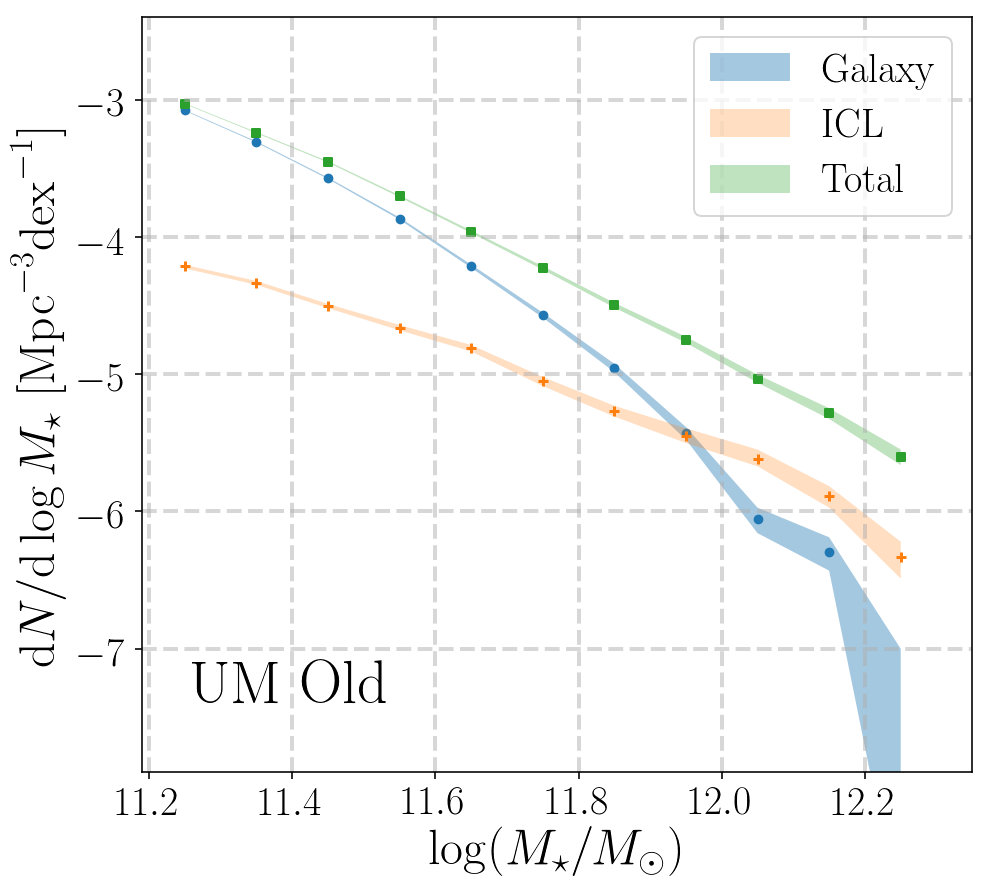

In [20]:
smf_mcmod_fig = show_smf([um_smf_gal, um_smf_icl, um_smf_tot_old],
                         [r'$\mathrm{Galaxy}$', r'$\mathrm{ICL}$', r'$\mathrm{Total}$'],
                         text=r'$\mathrm{UM\ Old}$')

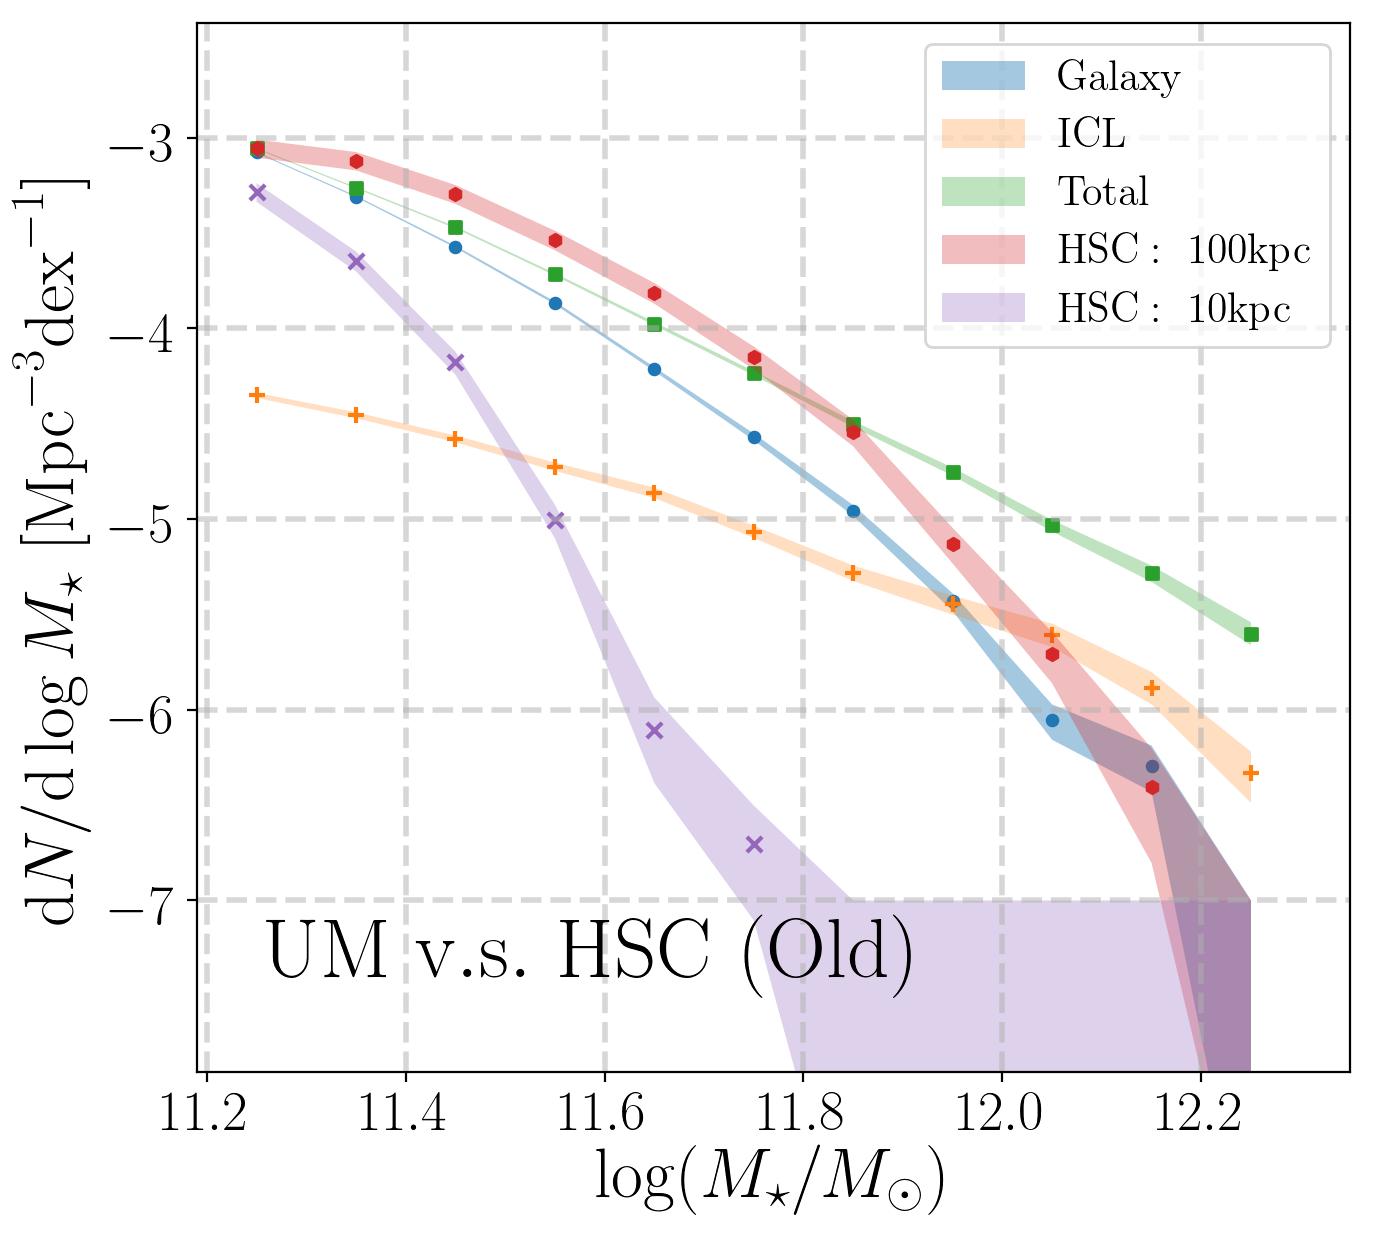

In [42]:
smf_mcmod_fig = show_smf([um_smf_gal, um_smf_icl, um_smf_tot_old, hsc_smf_m100, hsc_smf_m10],
                         [r'$\mathrm{Galaxy}$', r'$\mathrm{ICL}$', r'$\mathrm{Total}$', 
                          r'$\mathrm{HSC:\ 100kpc}$',
                          r'$\mathrm{HSC:\ 10kpc}$'],
                         text=r'$\mathrm{UM\ v.s.\ HSC\ (Old)}$', 
                         legend_fontsize=15)

In [21]:
um_smf_ins = mass_function.get_smf_bootstrap(
    logms_ins, um_smdpl_vol, 11, 11.2, 12.3, n_boots=100
)

um_smf_exs = mass_function.get_smf_bootstrap(
    logms_exs, um_smdpl_vol, 11, 11.2, 12.3, n_boots=100
)

um_smf_tot_new = mass_function.get_smf_bootstrap(
    logms_tot_new, um_smdpl_vol, 11, 11.2, 12.3, n_boots=100
)

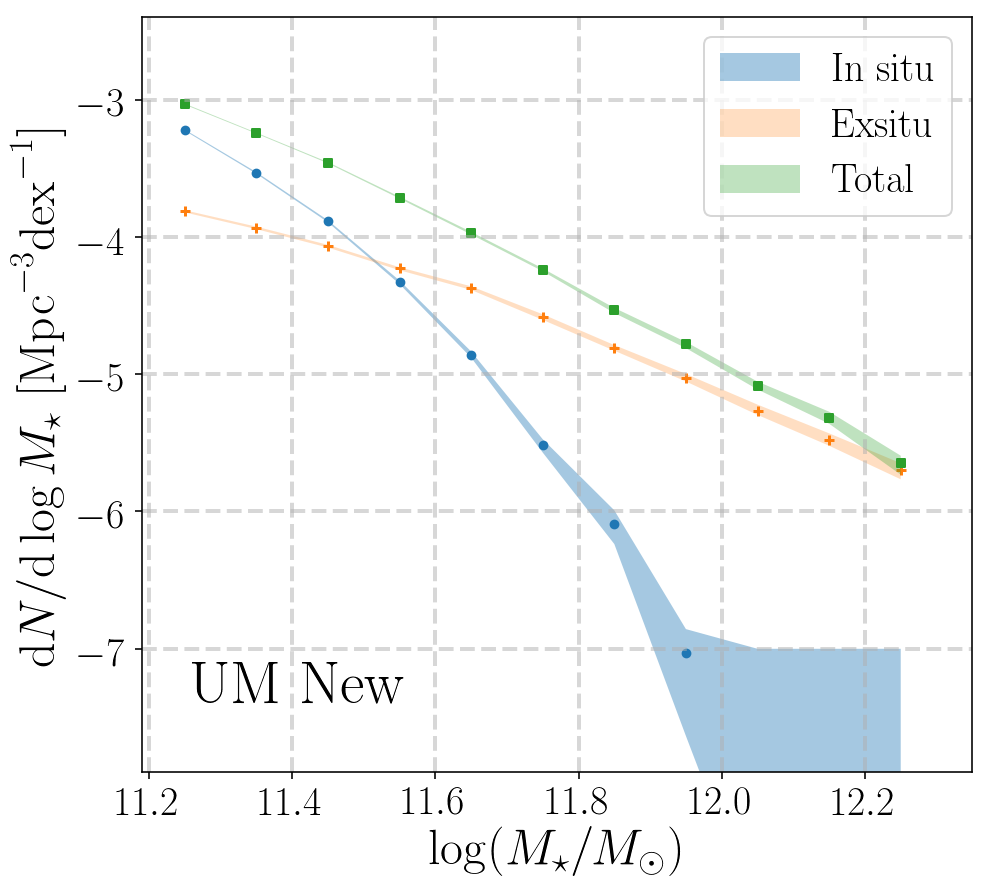

In [22]:
um_smf_new_fig = show_smf([um_smf_ins, um_smf_exs, um_smf_tot_new],
                          [r'$\mathrm{In\ situ}$', r'$\mathrm{Ex situ}$', r'$\mathrm{Total}$'],
                          text=r'$\mathrm{UM\ New}$')

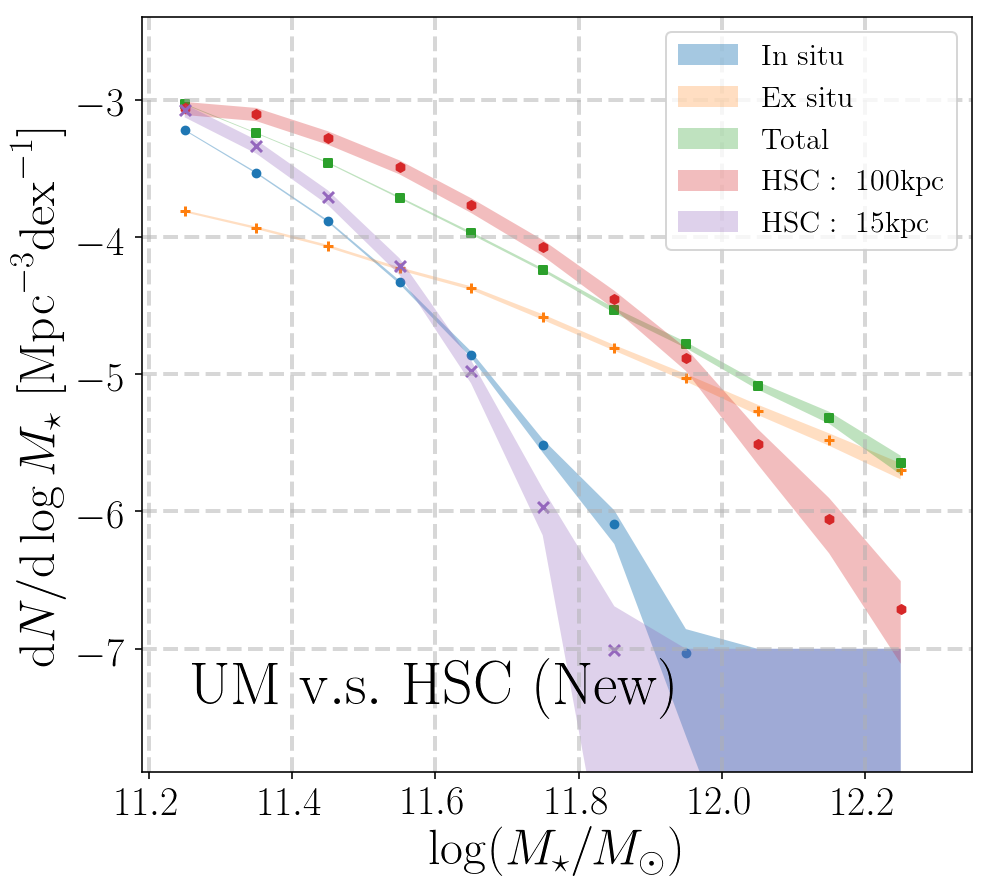

In [29]:
smf_mcmod_fig = show_smf([um_smf_ins, um_smf_exs, um_smf_tot_new, 
                          hsc_smf_mmax, hsc_smf_m15],
                         [r'$\mathrm{In\ situ}$', r'$\mathrm{Ex\ situ}$', r'$\mathrm{Total}$', 
                          r'$\mathrm{HSC:\ 100kpc}$',
                          r'$\mathrm{HSC:\ 15kpc}$'],
                         text=r'$\mathrm{UM\ v.s.\ HSC\ (New)}$', 
                         legend_fontsize=15)

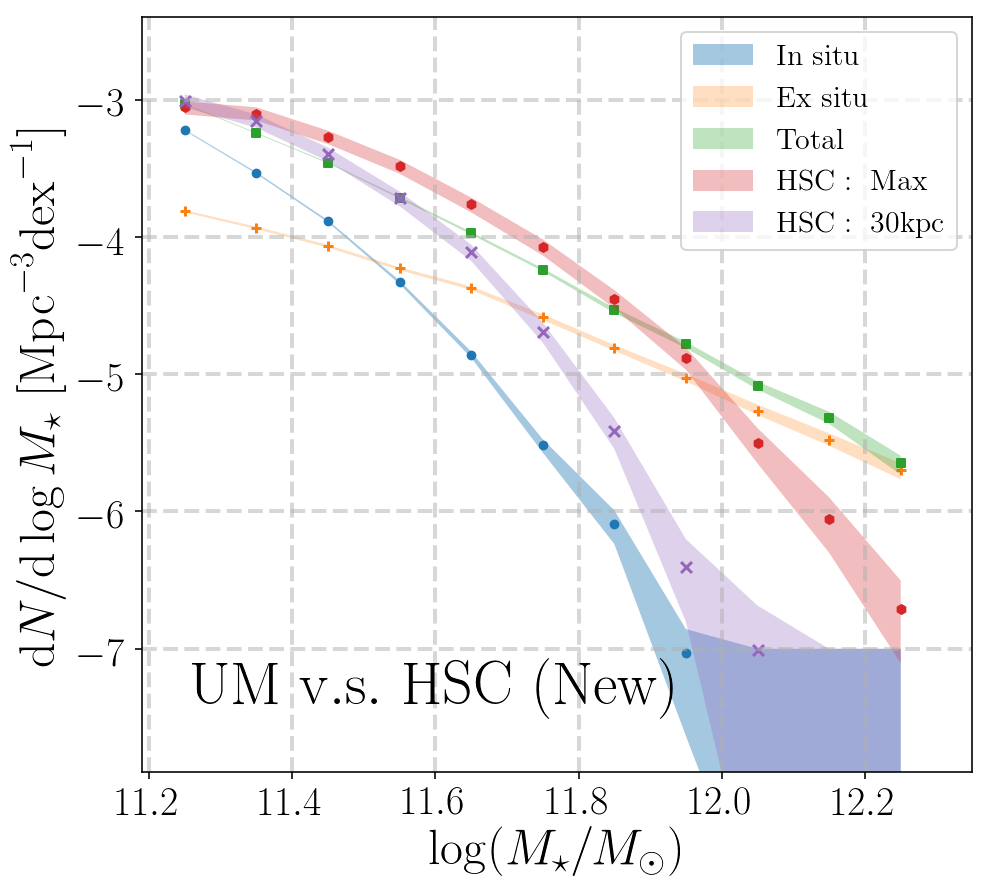

In [24]:
smf_mcmod_fig = show_smf([um_smf_ins, um_smf_exs, um_smf_tot_new, 
                          hsc_smf_mmax, hsc_smf_m30],
                         [r'$\mathrm{In\ situ}$', r'$\mathrm{Ex\ situ}$', r'$\mathrm{Total}$', 
                          r'$\mathrm{HSC:\ Max}$',
                          r'$\mathrm{HSC:\ 30kpc}$'],
                         text=r'$\mathrm{UM\ v.s.\ HSC\ (New)}$', 
                         legend_fontsize=15)

### Play around the in-situ and ex-situ model 

In [51]:
frac_ins_1 = 1.0
frac_exs_1 = 1.0

frac_ins_2 = 1.0
frac_exs_2 = 0.1

logms_um_100 = np.log10(frac_ins_1 * um_smdpl_new[sm_mask_new]['sm'] + 
                        frac_exs_1 * um_smdpl_new[sm_mask_new]['icl'])
logms_um_10  = np.log10(frac_ins_2 * um_smdpl_new[sm_mask_new]['sm'] + 
                        frac_exs_2 * um_smdpl_new[sm_mask_new]['icl'])

um_smf_100 = mass_function.get_smf_bootstrap(
    logms_um_100, um_smdpl_vol, 11, 11.2, 12.3, n_boots=100
)

um_smf_10 = mass_function.get_smf_bootstrap(
    logms_um_10, um_smdpl_vol, 11, 11.2, 12.3, n_boots=100
)



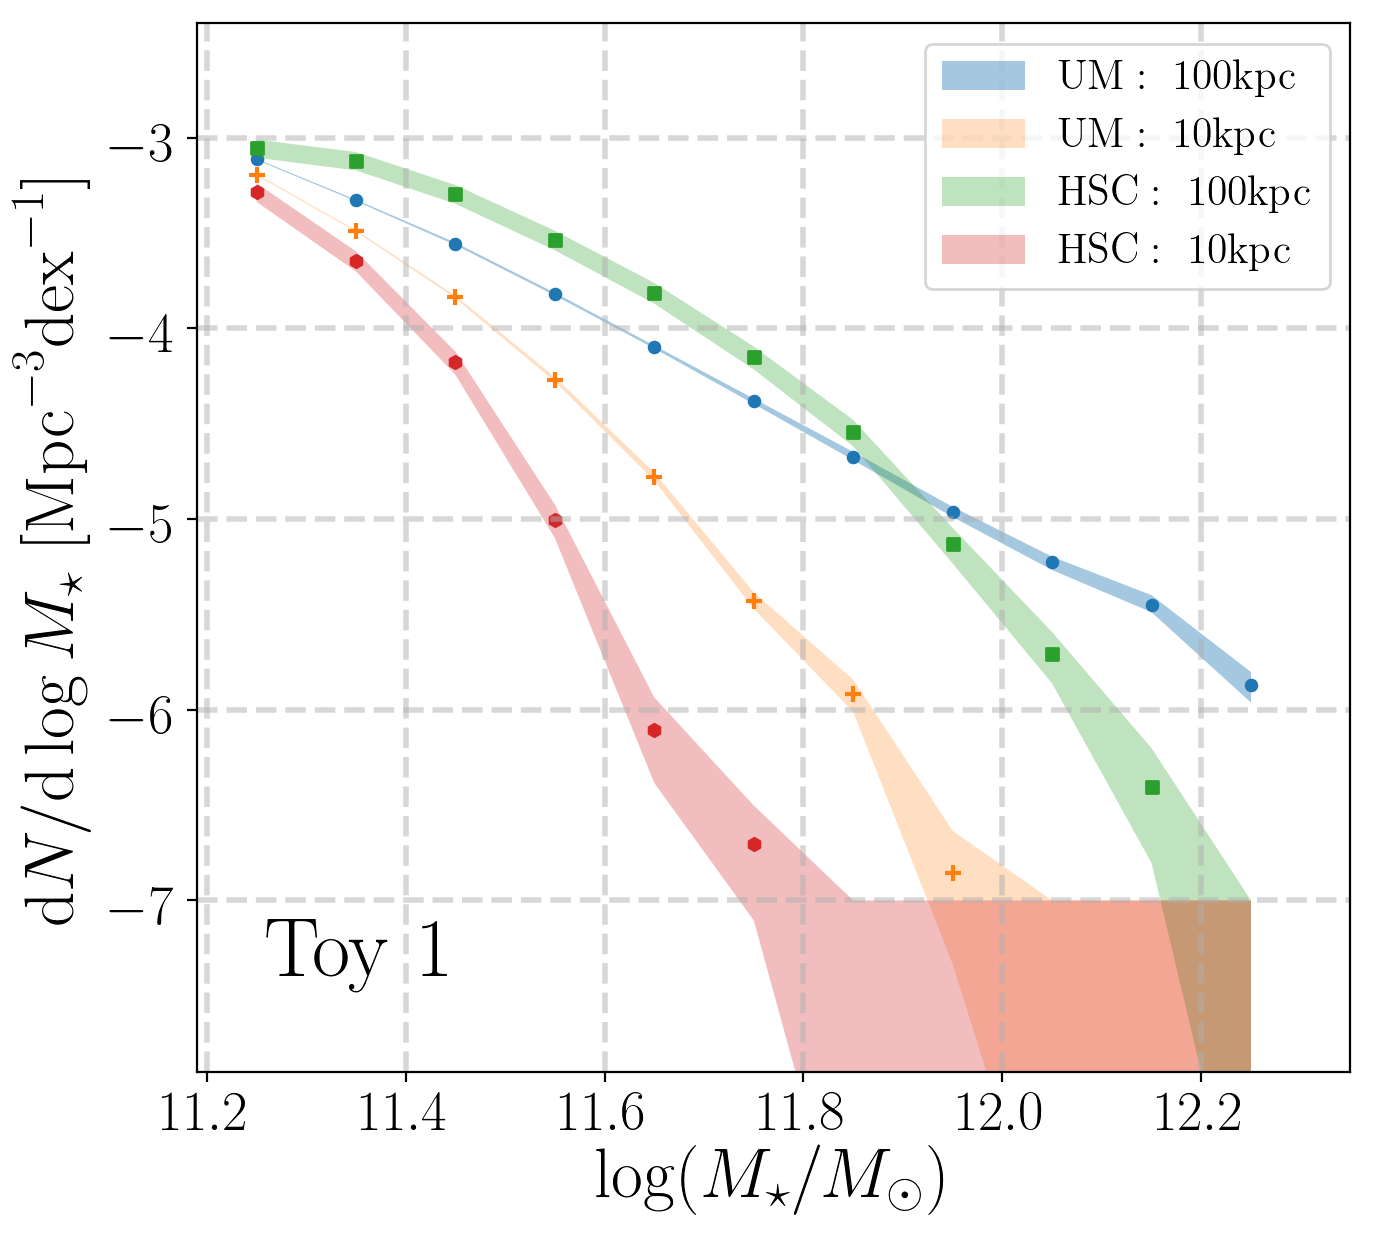

In [55]:
smf_mcmod_fig = show_smf([um_smf_100, um_smf_10, hsc_smf_m100, hsc_smf_m10],
                         [r'$\mathrm{UM:\ 100kpc}$', 
                          r'$\mathrm{UM:\ 10kpc}$', 
                          r'$\mathrm{HSC:\ 100kpc}$',
                          r'$\mathrm{HSC:\ 10kpc}$'],
                         text=r'$\mathrm{Toy\ 1}$', 
                         legend_fontsize=15)

In [59]:
frac_ins_1 = 1.0
frac_exs_1 = 0.9

frac_ins_2 = 0.7
frac_exs_2 = 0.1

logms_um_100 = np.log10(frac_ins_1 * um_smdpl_new[sm_mask_new]['sm'] + 
                        frac_exs_1 * um_smdpl_new[sm_mask_new]['icl'])
logms_um_10  = np.log10(frac_ins_2 * um_smdpl_new[sm_mask_new]['sm'] + 
                        frac_exs_2 * um_smdpl_new[sm_mask_new]['icl'])

um_smf_100 = mass_function.get_smf_bootstrap(
    logms_um_100, um_smdpl_vol, 11, 11.2, 12.3, n_boots=100
)

um_smf_10 = mass_function.get_smf_bootstrap(
    logms_um_10, um_smdpl_vol, 11, 11.2, 12.3, n_boots=100
)

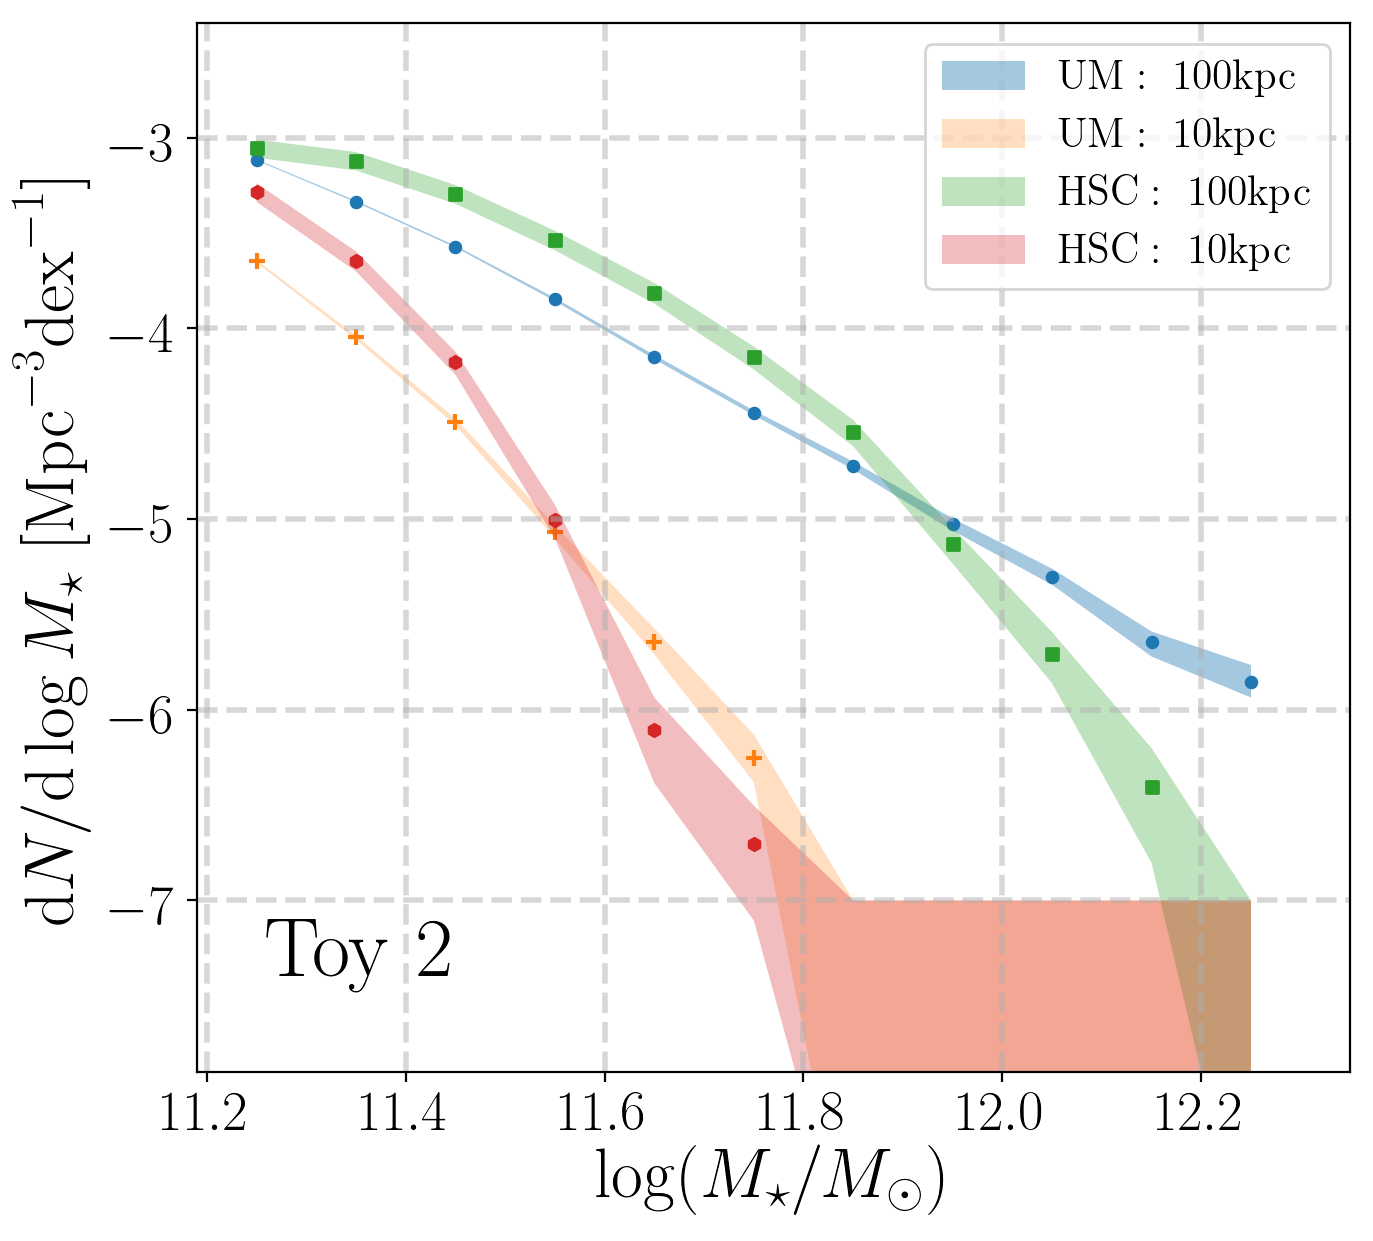

In [60]:
smf_mcmod_fig = show_smf([um_smf_100, um_smf_10, hsc_smf_m100, hsc_smf_m10],
                         [r'$\mathrm{UM:\ 100kpc}$', 
                          r'$\mathrm{UM:\ 10kpc}$', 
                          r'$\mathrm{HSC:\ 100kpc}$',
                          r'$\mathrm{HSC:\ 10kpc}$'],
                         text=r'$\mathrm{Toy\ 2}$', 
                         legend_fontsize=15)

### In-situ fraction with stellar and halo mass

In [85]:
um_smdpl_new_mass1 = um_smdpl_new[(um_smdpl_new['sm'] + um_smdpl_new['icl']) >= 1.0E11]
um_smdpl_new_mass2 = um_smdpl_new[(um_smdpl_new['sm'] + um_smdpl_new['icl']) >= 3.2E11]
print(len(um_smdpl_new_mass1), len(um_smdpl_new_mass2))

(120353, 8765)


In [86]:
um_smdpl_new_mcen1 = um_smdpl_new_cen[(um_smdpl_new_cen['sm'] + um_smdpl_new_cen['icl']) >= 1.0E11]
um_smdpl_new_mcen2 = um_smdpl_new_cen[(um_smdpl_new_cen['sm'] + um_smdpl_new_cen['icl']) >= 3.2E11]
print(len(um_smdpl_new_mcen1), len(um_smdpl_new_mcen2))

(89037, 7355)


Text(0,0.5,u'$M_{\\star,\\ \\mathrm{in-situ}}/ M_{\\star,\\ \\mathrm{total}}$')

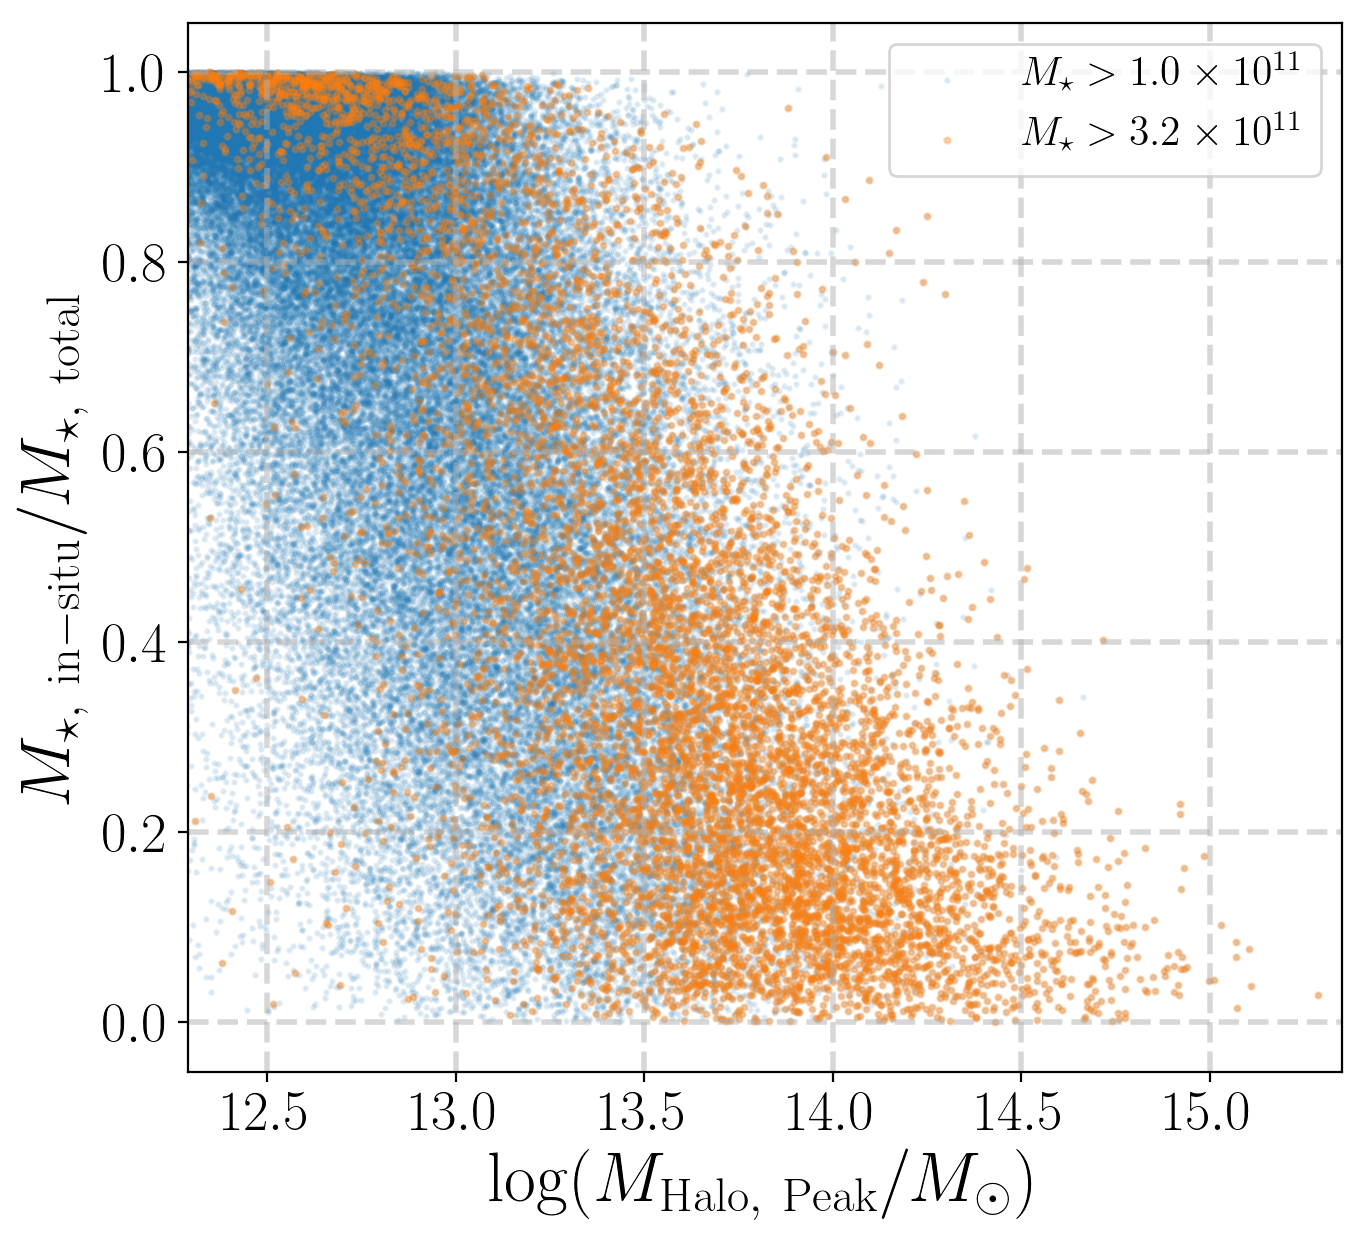

In [89]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.scatter(np.log10(um_smdpl_new_mass1['mp']), 
            (um_smdpl_new_mass1['sm'] / 
             (um_smdpl_new_mass1['sm'] + um_smdpl_new_mass1['icl'])),
            s=2, alpha=0.1, label=r'$M_{\star}>1.0\times10^{11}$')

ax1.scatter(np.log10(um_smdpl_new_mass2['mp']), 
            (um_smdpl_new_mass2['sm'] / 
             (um_smdpl_new_mass2['sm'] + um_smdpl_new_mass2['icl'])),
            s=4, alpha=0.3, label=r'$M_{\star}>3.2\times10^{11}$')

ax1.set_xlim(12.29, 15.35)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.legend(fontsize=15, loc=1)

ax1.set_xlabel(r'$\log (M_{\mathrm{Halo,\ Peak}}/M_{\odot})$',
               fontsize=25)
ax1.set_ylabel(r'$M_{\star,\ \mathrm{in-situ}}/ M_{\star,\ \mathrm{total}}$',
               fontsize=25)

Text(0,0.5,u'$M_{\\star,\\ \\mathrm{in-situ}}/ M_{\\star,\\ \\mathrm{total}}$')

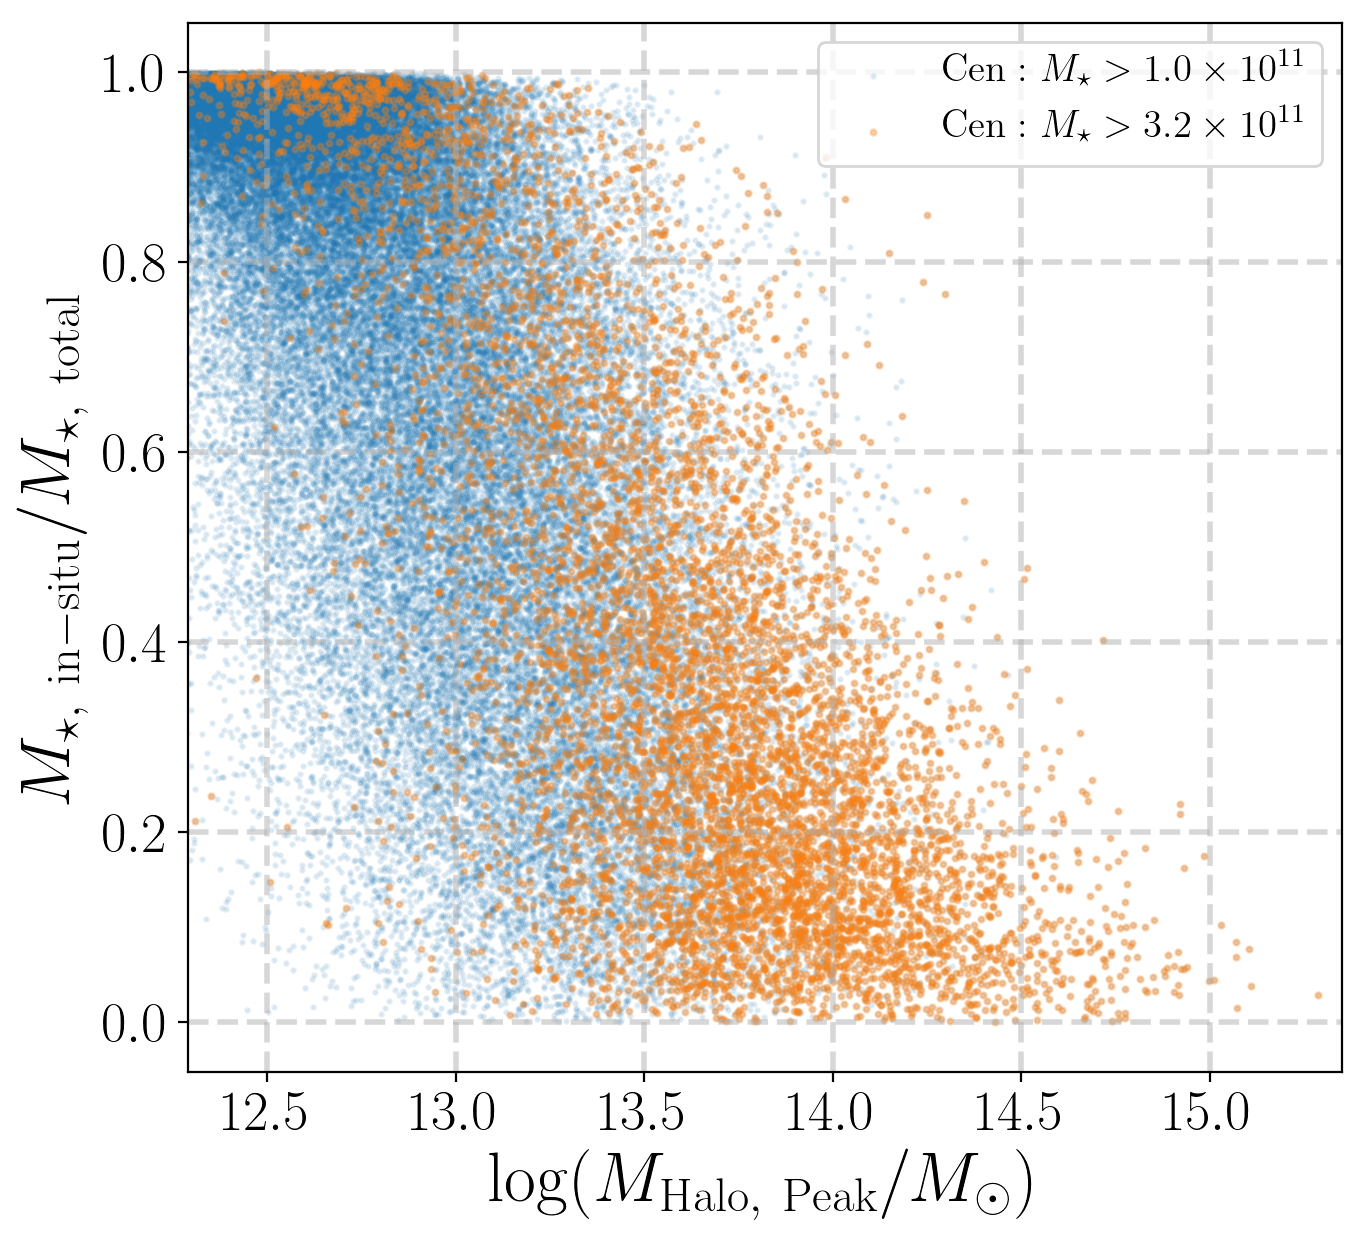

In [90]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.scatter(np.log10(um_smdpl_new_mcen1['mp']), 
            (um_smdpl_new_mcen1['sm'] / 
             (um_smdpl_new_mcen1['sm'] + um_smdpl_new_mcen1['icl'])),
            s=2, alpha=0.1, label=r'$\mathrm{Cen:}\ M_{\star}>1.0\times10^{11}$')

ax1.scatter(np.log10(um_smdpl_new_mcen2['mp']), 
            (um_smdpl_new_mcen2['sm'] / 
             (um_smdpl_new_mcen2['sm'] + um_smdpl_new_mcen2['icl'])),
            s=4, alpha=0.3, label=r'$\mathrm{Cen:}\ M_{\star}>3.2\times10^{11}$')

ax1.set_xlim(12.29, 15.35)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.legend(fontsize=14, loc=1)

ax1.set_xlabel(r'$\log (M_{\mathrm{Halo,\ Peak}}/M_{\odot})$',
               fontsize=25)
ax1.set_ylabel(r'$M_{\star,\ \mathrm{in-situ}}/ M_{\star,\ \mathrm{total}}$',
               fontsize=25)

Text(0,0.5,u'$M_{\\star,\\ \\mathrm{in-situ}}/ M_{\\star,\\ \\mathrm{total}}$')

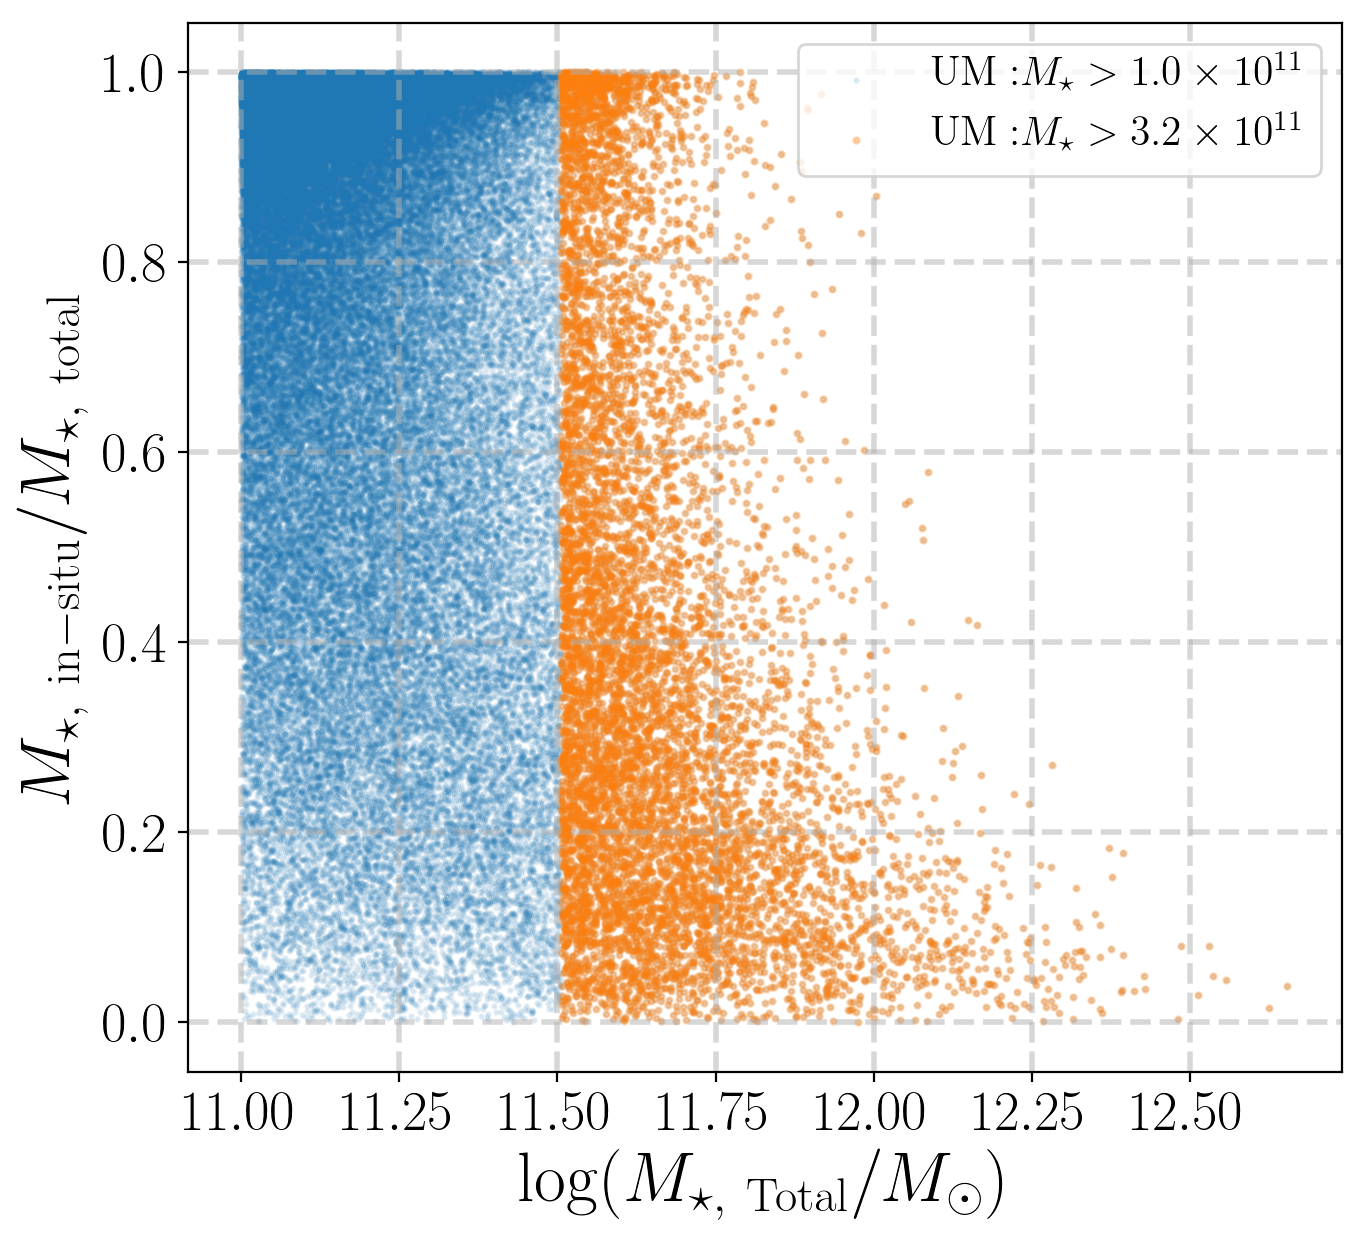

In [92]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.scatter(np.log10(um_smdpl_new_mass1['sm'] + um_smdpl_new_mass1['icl']), 
            (um_smdpl_new_mass1['sm'] / 
             (um_smdpl_new_mass1['sm'] + um_smdpl_new_mass1['icl'])),
            s=2, alpha=0.1, label=r'$\mathrm{UM:}M_{\star}>1.0\times10^{11}$')

ax1.scatter(np.log10(um_smdpl_new_mass2['sm'] + um_smdpl_new_mass2['icl']), 
            (um_smdpl_new_mass2['sm'] / 
             (um_smdpl_new_mass2['sm'] + um_smdpl_new_mass2['icl'])),
            s=4, alpha=0.3, label=r'$\mathrm{UM:}M_{\star}>3.2\times10^{11}$')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.legend(fontsize=15, loc=1)

ax1.set_xlabel(r'$\log (M_{\mathrm{\star,\ \mathrm{Total}}}/M_{\odot})$',
               fontsize=25)
ax1.set_ylabel(r'$M_{\star,\ \mathrm{in-situ}}/ M_{\star,\ \mathrm{total}}$',
               fontsize=25)

Text(0,0.5,u'$M_{\\star,\\ \\mathrm{in-situ}}/ M_{\\star,\\ \\mathrm{total}}$')

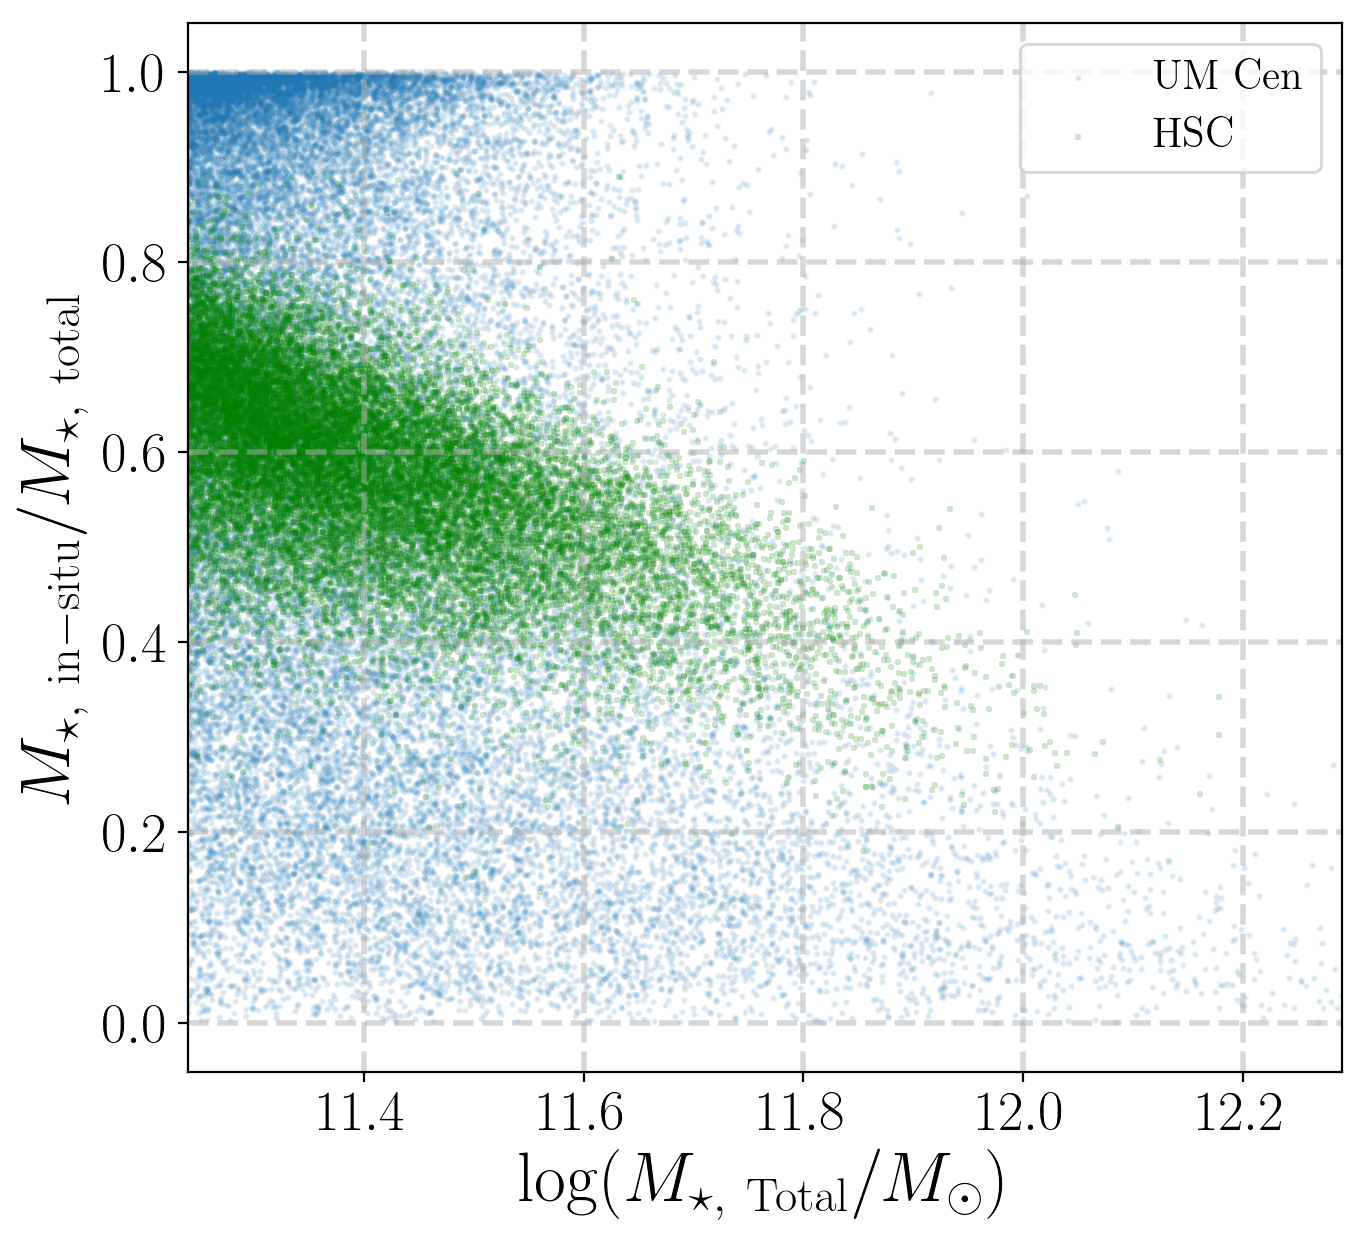

In [94]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.scatter(np.log10(um_smdpl_new_mcen1['sm'] + um_smdpl_new_mcen1['icl']), 
            (um_smdpl_new_mcen1['sm'] / 
             (um_smdpl_new_mcen1['sm'] + um_smdpl_new_mcen1['icl'])),
            s=2, alpha=0.1, label=r'$\mathrm{UM\ Cen}$')

ax1.scatter(hsc_mass['logm_100'], 
            (10.0 ** hsc_mass['logm_10']) / (10.0 ** hsc_mass['logm_100']),
            s=5, alpha=0.2, label=r'$\mathrm{HSC}$', marker='+', c='g')

ax1.set_xlim(11.24, 12.29)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.legend(fontsize=15, loc=1)

ax1.set_xlabel(r'$\log (M_{\mathrm{\star,\ \mathrm{Total}}}/M_{\odot})$',
               fontsize=25)
ax1.set_ylabel(r'$M_{\star,\ \mathrm{in-situ}}/ M_{\star,\ \mathrm{total}}$',
               fontsize=25)

Text(0,0.5,u'$\\log (M_{\\star,\\ \\mathrm{ex-situ}}/M_{\\odot})$')

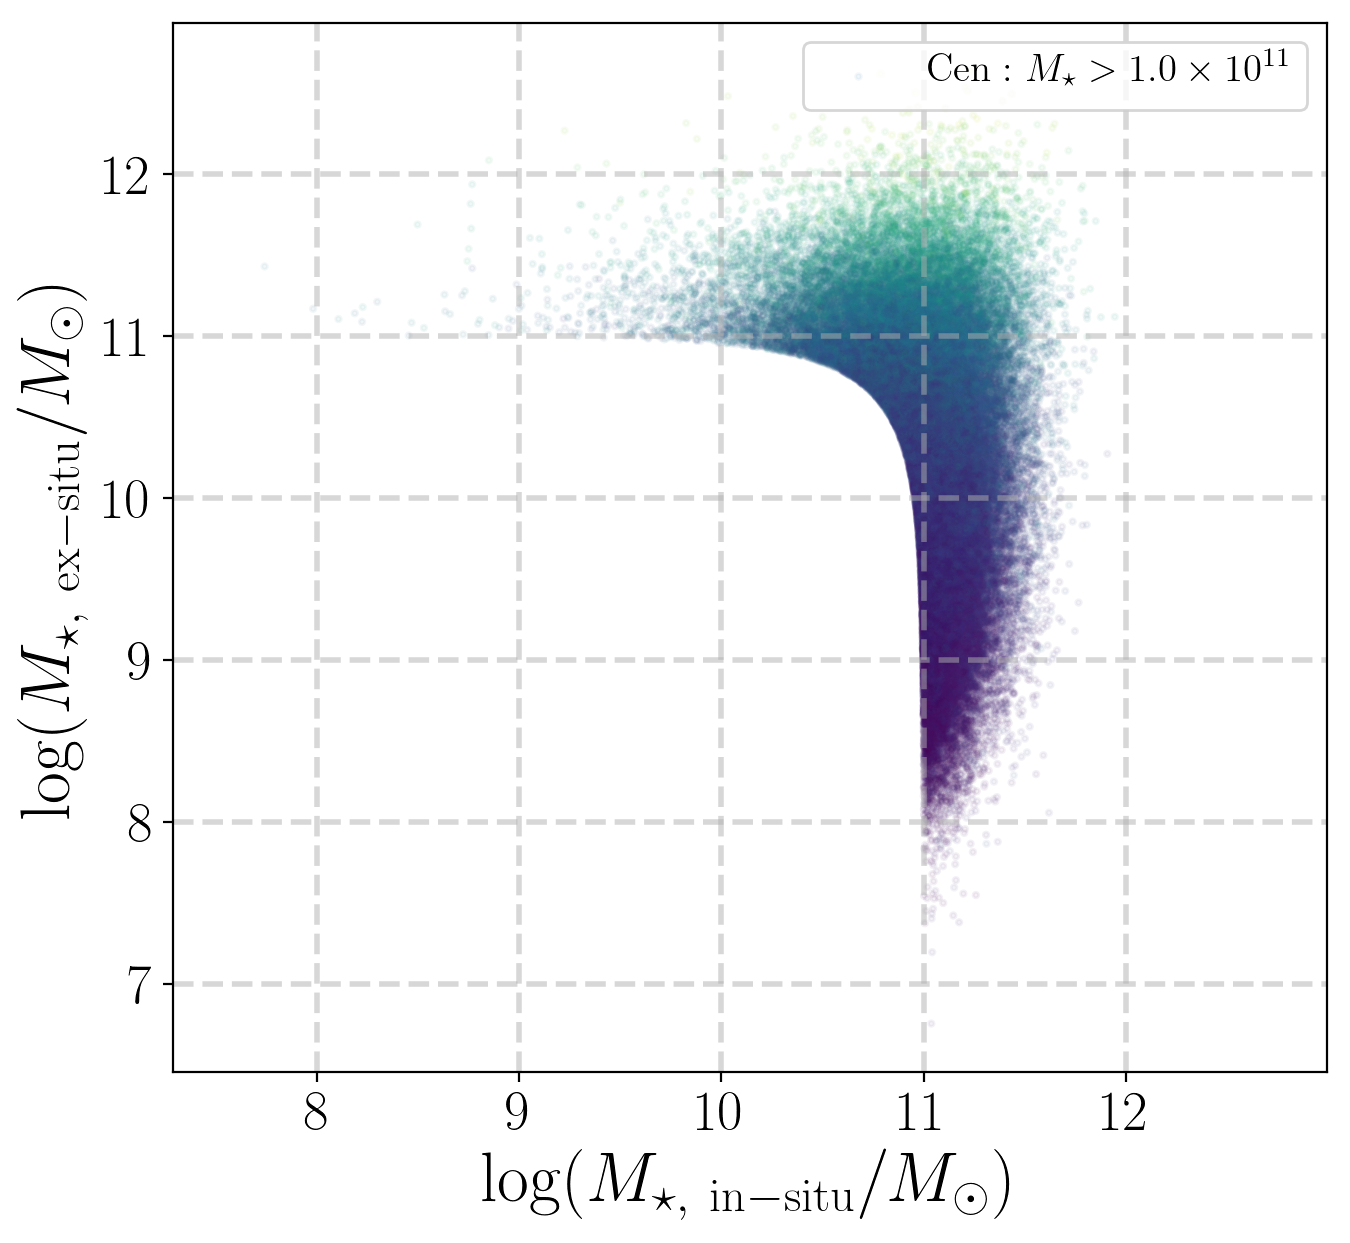

In [98]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.scatter(np.log10(um_smdpl_new_mcen1['sm']), 
            np.log10(um_smdpl_new_mcen1['icl']),
            c=np.log10(um_smdpl_new_mcen1['mp']),
            s=4, alpha=0.06, 
            label=r'$\mathrm{Cen:}\ M_{\star}>1.0\times10^{11}$')

ax1.set_xlim(9.29, 11.99)
ax1.set_xlim(7.29, 12.99)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.legend(fontsize=14, loc=1)

ax1.set_xlabel(r'$\log (M_{\star,\ \mathrm{in-situ}}/M_{\odot})$',
               fontsize=25)
ax1.set_ylabel(r'$\log (M_{\star,\ \mathrm{ex-situ}}/M_{\odot})$',
               fontsize=25)

Text(0,0.5,u'$\\log (M_{\\star,\\ \\mathrm{in-situ}}/M_{\\odot})$')

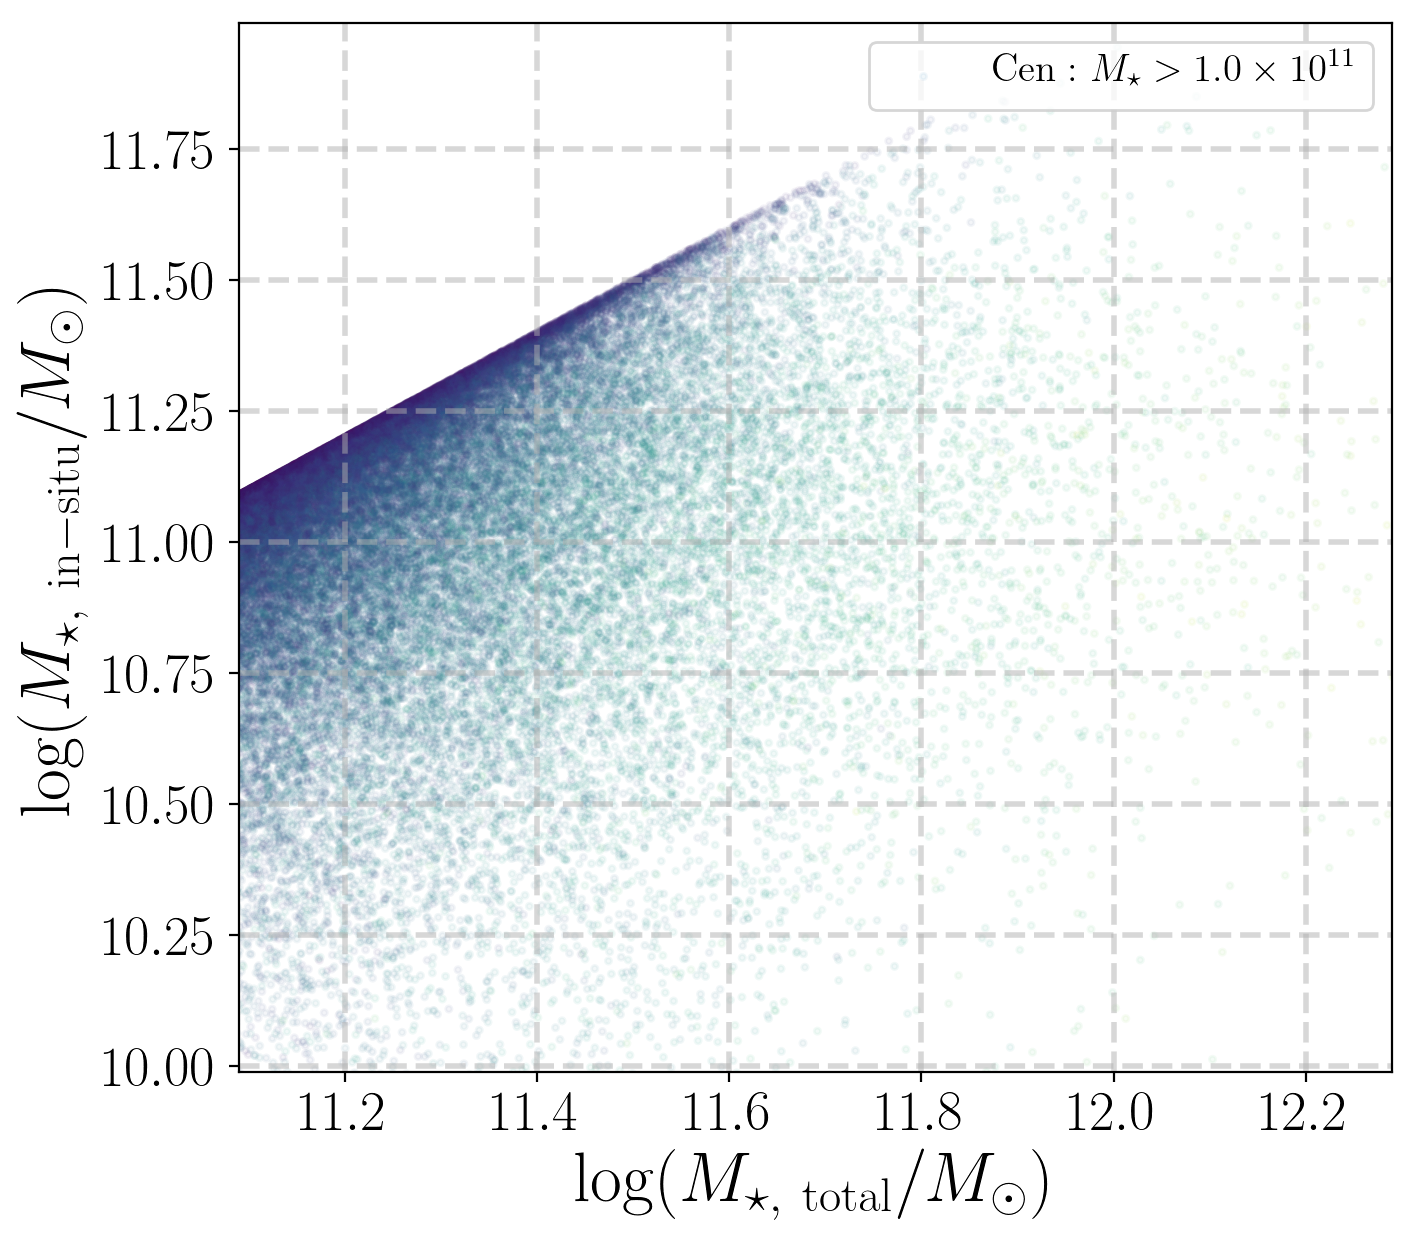

In [102]:
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(left=0.17, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

ax1.scatter(np.log10(um_smdpl_new_mcen1['sm'] + um_smdpl_new_mcen1['icl']), 
            np.log10(um_smdpl_new_mcen1['sm']),
            c=np.log10(um_smdpl_new_mcen1['mp']),
            s=5, alpha=0.06, 
            label=r'$\mathrm{Cen:}\ M_{\star}>1.0\times10^{11}$')

ax1.set_xlim(11.09, 12.29)
ax1.set_ylim(9.99, 11.99)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax1.legend(fontsize=14, loc=1)

ax1.set_xlabel(r'$\log (M_{\star,\ \mathrm{total}}/M_{\odot})$',
               fontsize=25)
ax1.set_ylabel(r'$\log (M_{\star,\ \mathrm{in-situ}}/M_{\odot})$',
               fontsize=25)